<center> <h1> User Spending Prediction - Model Building </h1> </center>

In [65]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dropout

In [66]:
user_df = pd.read_csv('processed data/userx.csv')

In [67]:
user_df

,InvoiceDate,Quantity,Price
0,2009-12-02 15:41:00,11,2.10
1,2009-12-02 15:41:00,1,2.10
2,2009-12-02 15:41:00,1,1.95
3,2009-12-02 15:41:00,1,3.75
4,2009-12-02 15:41:00,3,12.75
...,...,...,...
12633,2011-12-08 12:07:00,1,1.95
12634,2011-12-08 12:07:00,3,0.85
12635,2011-12-08 12:07:00,12,0.42
12636,2011-12-08 12:07:00,1,4.25


In [68]:
user_df['InvoiceDate'] = pd.to_datetime(user_df['InvoiceDate'])  
user_df.set_index('InvoiceDate', inplace=True)  

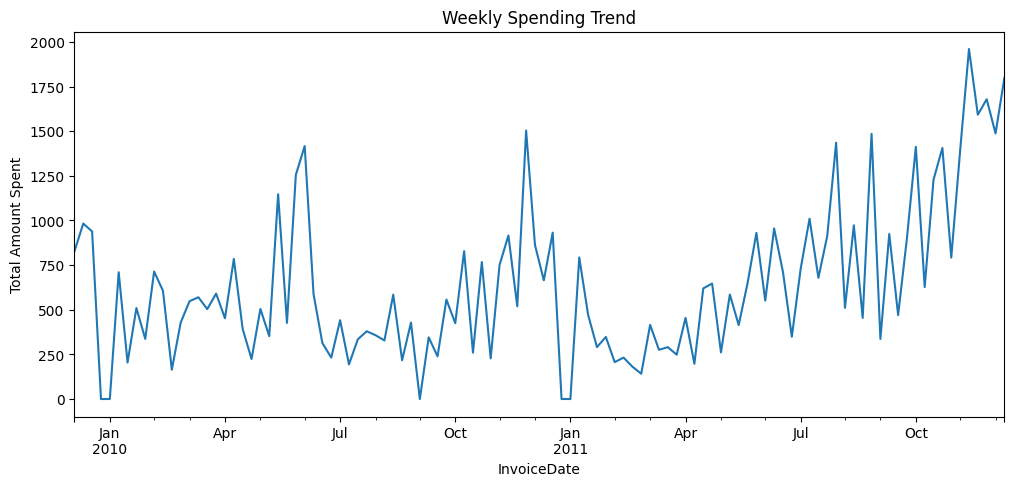

In [69]:
user_df['TotalAmount'] = user_df['Quantity'] * user_df['Price']
weekly_spending = user_df['TotalAmount'].resample('W').sum()
weekly_spending.plot(title='Weekly Spending Trend', figsize=(12, 5))
plt.ylabel('Total Amount Spent')
plt.show()


In [70]:
# Nomalizing Data for Training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_spending.values.reshape(-1, 1))

In [71]:
# Converting the dataframe value to sequences of 4 for tensorflow input layer
# X = [wk1,wk2,wk3,wk4]
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4
X, y = create_sequences(scaled_data, window_size)

In [72]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [78]:
lookback = 5
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))


Epoch 1/40


/mnt/Data/Projects/User-Expenses-Prediction/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0934 - val_loss: 0.3517
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0820 - val_loss: 0.2923
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0562 - val_loss: 0.2354
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0460 - val_loss: 0.1798
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0364 - val_loss: 0.1298
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0219 - val_loss: 0.0920
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0251 - val_loss: 0.0708
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0276 - val_loss: 0.0699
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0324 - val_loss: 0.0816
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0259 - val_loss: 0.0971
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0281 - val_loss: 0.1105
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0231 - val_loss: 0.1204
Epoch 13/40

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


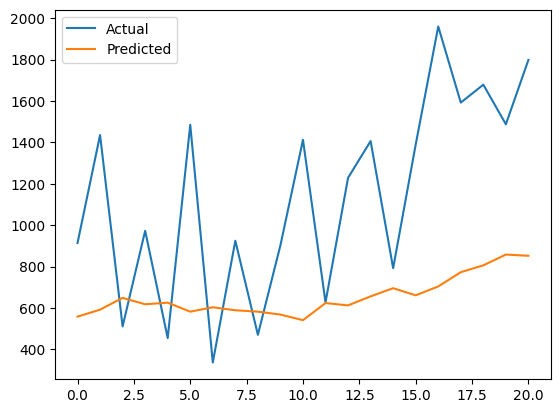

In [74]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()


In [75]:
predicted

array([[557.7396 ],
       [591.51776],
       [648.4231 ],
       [617.65076],
       [625.30634],
       [581.8581 ],
       [603.0942 ],
       [588.5133 ],
       [581.8891 ],
       [567.75653],
       [540.7133 ],
       [623.461  ],
       [612.11206],
       [655.75   ],
       [695.2068 ],
       [660.76263],
       [703.7635 ],
       [772.635  ],
       [805.78345],
       [857.7212 ],
       [851.8187 ]], dtype=float32)

In [76]:
actual

array([[ 913.49],
       [1435.28],
       [ 510.38],
       [ 972.63],
       [ 454.34],
       [1484.81],
       [ 336.29],
       [ 924.48],
       [ 470.05],
       [ 902.46],
       [1412.12],
       [ 626.76],
       [1228.64],
       [1406.13],
       [ 791.82],
       [1389.43],
       [1959.87],
       [1592.11],
       [1678.67],
       [1487.29],
       [1798.59]])